In [9]:
import sys
sys.path.append('C:/Users/shjo/Bridge/JNUpack/mySO_src/libs/')
import matplotlib as mpl
# mpl.use('agg')
from myPlot import  figmaster,myClrbr
from myTools import myInfo
import matplotlib.path as mpath
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gsw.density as gsw_d
import gsw.conversions as gsw_c
import os
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from eofs.xarray import Eof
import numpy as np
import xarray as xr
import pickle
from myTrend import myfitting2d_sttcs,myfitting1d_sttcs
from myPlot import  figmaster,myClrbr, dta_colr
import matplotlib.pyplot as plt
from scipy.interpolate import griddata 
import warnings
import colormaps as cmaps
warnings.filterwarnings('ignore')

pthmd='J:/tmp_proc/Models/'
pthob='J:/tmp_proc/Obs/'

wpth='C:/Users/shjo/OneDrive/mySO/Trend/'

lat_rng=[-70,-30]; lon_rng=[200,220]; depth_rng=[0,2000]

t_rng=[1993, 2017]
varnm='salt'
fig_bool=1

### Preparation ============================================================
time_rng=[str(t_rng[0])+'-01',str(t_rng[-1])+'-12']
tmp_sv_nm=str(lon_rng[0])+'E'+str(lon_rng[-1])+'E'+'_'+str(lat_rng[0])+'S'+str(lat_rng[-1])+'S'
tmp_sv_nm=tmp_sv_nm.replace('-','')
# wpth=wpth+varnm+'_'+tmp_sv_nm+'/'

wpth_re=wpth+varnm+'_'+str(t_rng[0])+'_'+str(t_rng[-1])+'_'+tmp_sv_nm+'/'
try :
    os.mkdir(wpth_re)
except:
    pass
# loc=sys._getframe().f_code.co_filename
# myInfo(loc,wpth_re)

# myRnly=[pthrn+i for i in os.listdir(pthrn) if i.endswith('.nc')]
myMdls=[pthmd+i for i in os.listdir(pthmd) if i.endswith('.nc')]
myObsv=[pthob+i for i in os.listdir(pthob) if i.endswith('.nc')]

myDATA=myMdls+myObsv

if t_rng[0]<1992:
    myDATA=[i for i in myDATA if not i.split('/')[-1].startswith('myECCO')]
    myDATA=[i for i in myDATA if not i.split('/')[-1].startswith('myISAS')]
    myDATA=[i for i in myDATA if not i.split('/')[-1].startswith('myARMOR3D')]

plt.rcParams["font.family"] = 'Arial'

myN=20
mylim=[-.02,.02]
mydepth=[-250, -500, -1000, -1500,-2000]
# mydepth=[-250, -500, -800]

mylevels2=[-0.001,1.5,4.5,8,11]

mySetting={
    'figsize': '',
    'mylabel': '',
    'Label_size':12,
    'title_loc':'right',
    'fontParams':'Arial',
    'wpth':wpth}

F=figmaster(mySetting)

def Vertical_data_drift03_(latR_m,depthR_m,dataR,mydepth,CMAP,myLevels1,myLevels2,dt_nm,snm):
    Label_size=12
    xtick_location = np.around(np.linspace(latR_m[0,0], latR_m[-1,-1],5))
    xtick_location = np.around(np.arange(latR_m[0,0]-1,latR_m[-1,-1]+1,5)+0.75)
    xtick_labels = [f'{-ii:2.0f}S' for ii in xtick_location]
    # xtick_labels = [str(-ii)+'S' for ii in xtick_location]
    ytick_location= mydepth
    ytick_labels  = [f'{-ii:2.0f}m' for ii in ytick_location]
    # Figures
    fig, axs = plt.subplots(1,1,figsize=(8,4),
                            sharex=True,gridspec_kw={'height_ratios': [1],'wspace':0, 'hspace':0.05},dpi=200)
    # im1=axs.pcolor(latR_m,depthR_m,dataR,cmap=CMAP,vmin=data_lim[0],vmax=data_lim[-1])
    axs.set_title(dt_nm,loc='right',fontdict={'fontsize':Label_size+4,'fontweight':'regular'})
    axs.axvline(x=-60,ls='--',color='k')
    axs.axvline(x=-50,ls='--',color='k')
    
    im1=axs.contourf(latR_m,depthR_m,dataR,cmap=CMAP,levels=myLevels1)
    # axs.clabel(im1, inline=1, fontsize=14)
    axs.tick_params(axis='x', direction='in', length=4.5, pad=8, labelsize=Label_size, labelcolor='k', top=True)
    axs.tick_params(axis='y', direction='in', length=4.5, pad=8, labelsize=Label_size, color='k',right=True)
    # axs.set_ylim(-NC['Tcline'].values[0],0) 
    # plt.grid(color='grey', linestyle='-.', linewidth=1,axis='y',alpha=.7)
    axs.set_xlim(latR_m[0,0],latR_m[-1,-1])
    im0=axs.contour(latR_m,depthR_m,dataR,\
        colors='k',levels=myLevels2,linestyle='-')
    axs.clabel(im0, inline=1, fontsize=10)
    axs.set_xticks(ticks=xtick_location)
    axs.set_xticklabels(xtick_labels, rotation=0, fontsize=Label_size, alpha=1.)
    axs.set_yticks(ticks=ytick_location)
    axs.set_yticklabels(ytick_labels, rotation=0, fontsize=Label_size, alpha=1.)
    axs.set_facecolor(color='#dddddd')
    divider = make_axes_locatable(axs)
    cax = divider.append_axes("bottom", size="7%", pad=.35)
    cax.tick_params(labelsize=Label_size)
    cax.set_ylabel('',{'fontsize':Label_size,'fontweight':'bold','style':'italic'})
    h = fig.colorbar(im1, ax=axs,label='',cax=cax,orientation="horizontal",extend='both',aspect=50)
    if 1:
        # plt.savefig('',facecolor='none',edgecolor='none',bbox_inches='tight',transparent=True)
        plt.savefig(snm,bbox_inches='tight')
    plt.show()
    

def Vertical_data_drift03_hat(latR_m,depthR_m,dataR,myrho,Hatch,mydepth,CMAP,myLevels1,myLevels2,dt_nm,snm):
    Label_size=12
    xtick_location = np.around(np.linspace(latR_m[0,0], latR_m[-1,-1],5))
    xtick_location = np.around(np.arange(latR_m[0,0]-1,latR_m[-1,-1]+1,5)+0.75)
    xtick_labels = [f'{-ii:2.0f}S' for ii in xtick_location]
    # xtick_labels = [str(-ii)+'S' for ii in xtick_location]
    ytick_location= mydepth
    ytick_labels  = [f'{-ii:2.0f}m' for ii in ytick_location]
    # Figures
    fig, axs = plt.subplots(1,1,figsize=(8,4),
                            sharex=True,gridspec_kw={'height_ratios': [1],'wspace':0, 'hspace':0.05},dpi=200)
    # im1=axs.pcolor(latR_m,depthR_m,dataR,cmap=CMAP,vmin=data_lim[0],vmax=data_lim[-1])
    axs.set_title(dt_nm,loc='right',fontdict={'fontsize':Label_size+4,'fontweight':'regular'})
    axs.axvline(x=-60,ls='--',color='k')
    axs.axvline(x=-50,ls='--',color='k')
    # axs.clabel(im1, inline=1, fontsize=14)
    axs.tick_params(axis='x', direction='in', length=4.5, pad=8, labelsize=Label_size, labelcolor='k', top=True)
    axs.tick_params(axis='y', direction='in', length=4.5, pad=8, labelsize=Label_size, color='k',right=True)
    # axs.set_ylim(-NC['Tcline'].values[0],0) 
    # plt.grid(color='grey', linestyle='-.', linewidth=1,axis='y',alpha=.7)
    axs.set_xlim(latR_m[0,0],latR_m[-1,-1])
    im1=axs.contour(latR_m,depthR_m,myrho,\
        colors='k',linestyle='-',levels=myLevels2)
    axs.clabel(im1, inline=1, fontsize=10)
    plt.contourf(latR_m,depthR_m,Hatch,levels=myLevels1,colors='none',hatches='/',zorder=2,extend='both')
    im1=axs.contourf(latR_m,depthR_m,dataR,cmap=CMAP,levels=myLevels1)
    
    axs.set_xticks(ticks=xtick_location)
    axs.set_xticklabels(xtick_labels, rotation=0, fontsize=Label_size, alpha=1.)
    axs.set_yticks(ticks=ytick_location)
    axs.set_yticklabels(ytick_labels, rotation=0, fontsize=Label_size, alpha=1.)
    axs.set_facecolor(color='#dddddd')
    divider = make_axes_locatable(axs)
    cax = divider.append_axes("bottom", size="7%", pad=.35)
    cax.tick_params(labelsize=Label_size)
    cax.set_ylabel('',{'fontsize':Label_size,'fontweight':'bold','style':'italic'})
    h = fig.colorbar(im1, ax=axs,label='',cax=cax,orientation="horizontal",extend='both',aspect=50)
    if 1:
        # plt.savefig('',facecolor='none',edgecolor='none',bbox_inches='tight',transparent=True)
        plt.savefig(snm,bbox_inches='tight')
    plt.show()

!!! Open: J:/tmp_proc/Obs/myISHII_195501_202212_tsh.nc !!!
!!! linregress !!!


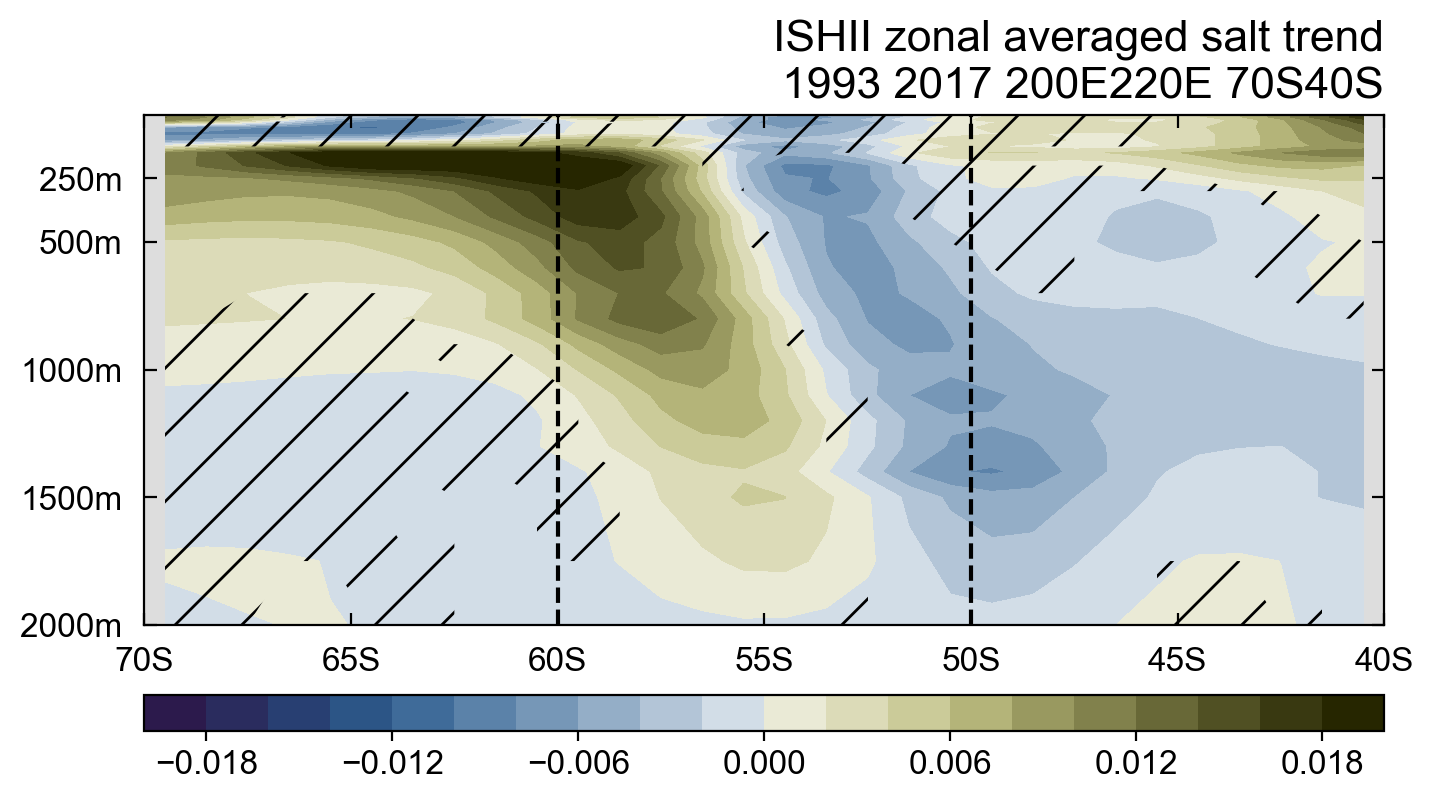

In [10]:


for i in [myDATA[-1]]: 
    print('!!! Open: '+i+' !!!')
    tmp=xr.open_dataset(i)

    mydata = tmp.loc[dict(lat=slice(lat_rng[0],lat_rng[-1]),lon=slice(lon_rng[0],lon_rng[-1]),\
        time=slice(time_rng[0],time_rng[-1]),depth=slice(depth_rng[0],depth_rng[-1]))]
    mydata=mydata.where(mydata<10**10)
    mydata=mydata.where(mydata>-10**10)
    
    
    ### Calc density ================================
    mydata_=mydata.mean(dim=['time','lon'])
    temp_,salt_=mydata_['temp'],mydata_['salt']
    CT=gsw_c.CT_from_pt(salt_,temp_) #CT = gsw_CT_from_pt(SA,pt)
    # rho = gsw_d.rho(salt_,CT,depthR)
    rho = gsw_d.sigma0(salt_,CT)
    ### =============================================
    
    mydata=mydata[varnm].mean(dim=['lon'],skipna=True)

    latR,depthR=mydata.lat.values,mydata.depth.values
    dta_nm=i.split('/')[-1][2:-3].split('_')[0]+\
        ' zonal averaged '+varnm+' trend\n'+str(t_rng[0])+' '+str(t_rng[-1])+' '+tmp_sv_nm.replace('_' ,' ')
    dta_snm=wpth_re+dta_nm.replace(' ','_').replace('\n','_')

    latR_m,depthR_m=np.meshgrid(latR,depthR)
    
    print('!!! linregress !!!')
    slope,intercept,r_value,p_value,std_err,smask=myfitting2d_sttcs(mydata,threshold=0.05)
    CoefD=slope*12*10  # year^-1

    CoefD[CoefD>mylim[-1]]=mylim[-1]
    CoefD[CoefD<mylim[0]]=mylim[0]
    
    CMAP_temp,mylevel=myClrbr('b2r',mylim,myN)
    CMAP_salt,mylevel=myClrbr('salt',mylim,myN)
    
    smask[smask!=smask]=1
    smask[smask==0]=np.nan
    smask[smask==1]=0

    
    Vertical_data_drift03_hat(latR_m,-depthR_m,CoefD,rho,smask,mydepth,CMAP_salt,mylevel,mylevels2,dta_nm,dta_snm)
